In [118]:
import os
os.environ["SCIPY_USE_PROPACK"] = "1"

In [119]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import networkx as nx
import scipy
%matplotlib inline

In [120]:
plt.rcParams['figure.figsize'] = [15, 10]
sns.set_style('whitegrid')
plt.rcParams['font.size'] = 20.0
plt.rcParams['xtick.labelsize'] = 20.0
plt.rcParams['ytick.labelsize'] = 20.0
import pickle

In [32]:
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [33]:
import graph_learning_utils as gl

# Summary of this notebook

* Implement faster, sparse-matrix based ways of generate Boolean sampling data

* Implement a simple occlusion method that zeroes out rows/columns of a matrix

* Test the solver on occluded versions of human PPI data. Unfortunately, it is simply too slow. 

We need to either run sparsity based methods, or implement on GPUs. 

* Try making scipy solver work with sparse data.

* Try BFGS and compare its speed

# Occlusion model 

We are given a ground truth $A^s$ through an unbiased sampling procedure from the base PPI. 

We generate some number of P_i by knocking certain edges from P, then sampling from than biased version to get P_i. 

Run the algorithm, then ask: 

* How many edges can we recover?

Can use the usual binary classification metrics, e.g. precision, recall, F1, etc.

## Import data

In [5]:
sparse_matrix = scipy.sparse.load_npz('data/adj_matrix_sparse_restricted_9606.npz')
max_degree =  np.max(sparse_matrix)
sparse_matrix /= max_degree

In [6]:
sparse_matrix

<11916x11916 sparse matrix of type '<class 'numpy.float64'>'
	with 5963604 stored elements in Compressed Sparse Row format>

In [7]:
max_degree =  np.max(sparse_matrix)
sparse_matrix /= max_degree

### faster bernoulli sampling

In [79]:
def gen_occluded_p(sparse_M, frac_to_occlude = 0.01): 
    n = sparse_M.shape[0]
    num_to_occlude = int(frac_to_occlude * n)
    occluded_indices = np.random.choice(n, size=num_to_occlude, replace=False)
    return zero_rows_cols(sparse_M, occluded_indices)

def zero_rows_cols(M, row_indices):
    '''
    Zeroes out the rows/cols in row_indices. 
    M is a sparse matrix type. 
    '''
    diag = scipy.sparse.eye(M.shape[0]).tolil()
    for r in row_indices:
        diag[r, r] = 0
    return diag.dot(M).dot(diag)

def bin_samples_rand2(n, mu):
    '''
    mu: List of floats in [0,1] describing Bernoulli mean probabilities. 
    n: number of samples per entries of mu. 
    '''
    rng = np.random.default_rng()
    return (rng.random(size=(len(mu), n)) < mu[:, None]).astype(np.uint8)

def gen_sparse_sample_boolean_mat(sparse_mat): 
    nonzero_float_entries = scipy.sparse.triu(sparse_mat, k=1).data
    sparse_tri = scipy.sparse.csr_matrix(scipy.sparse.triu(sparse_mat, k = 1))
    sample_bool = bin_samples_rand2(1, nonzero_float_entries).squeeze(-1)
    sparse_tri.data = sample_bool
    symm_sparse = sparse_tri + sparse_tri.T
    return symm_sparse

In [52]:
m = 5 
occluded_ground_truths = [gen_occluded_p(sparse_matrix) for _ in range(m)]

In [ ]:
# nonzero_float_entries = scipy.sparse.triu(sparse_matrix, k=1).data
# sparse_tri = scipy.sparse.csr_matrix(scipy.sparse.triu(sparse_matrix, k = 1))
# sample_bool = bin_samples_rand2(1, nonzero_float_entries).squeeze(-1)
# sparse_tri.data = sample_bool
# symm_sparse = sparse_tri + sparse_tri.T

In [55]:
validation_mat = gen_sparse_sample_boolean_mat(sparse_matrix)
sample_mats = [gen_sparse_sample_boolean_mat(occluded_ground_truth) for occluded_ground_truth in occluded_ground_truths]

## rewrite algo for sparse matrices

In [195]:
def objective_with_params_sparse(eta_arr, validation_mat, sample_mats, delta, num_eigs_included=None, verbose=False):
    if num_eigs_included is None:
        num_eigs_included = validation_mat.shape[0]
    P_hat = gl.matrix_lin_combo_pos_sign(eta_arr, sample_mats, sparse=True)

    # singular values, increasing order
    # print('running svd with {} singular values'.format(num_eigs_included))
    diff_sing_values = scipy.sparse.linalg.svds(validation_mat - P_hat, solver='arpack',
                                                k=num_eigs_included - 1, return_singular_vectors=False)

    def ob_fn(k): 
        return sum(diff_sing_values[-k:]) - k * delta

    all_obj_values = [ob_fn(k) for k in range(1, num_eigs_included + 1)]
    max_obj_index = np.argmax(all_obj_values)
    # print(all_obj_values, max_obj_index)
    return all_obj_values[max_obj_index]

### generate random sparse data

In [93]:
m = 5
n = 100
r_data = np.random.uniform(low=0, high=0.5, size=n * n).reshape(n, n)
sparse_mat_simul = scipy.sparse.csr_matrix(r_data + r_data.T)
validation_mat = gen_sparse_sample_boolean_mat(sparse_mat_simul)

other_data = np.random.uniform(low=0, high=0.5, size=n * n).reshape(n, n)
other_data_simul = scipy.sparse.csr_matrix(r_data + r_data.T)
sample_mats = [gen_sparse_sample_boolean_mat(other_data_simul) for _ in range(m)]

In [81]:
eta_init = gl.generate_random_eta(m)

In [82]:
validation_mat.shape

(10, 10)

In [38]:
# delta = 0.0
# objective = lambda eta_arr: objective_with_params_sparse(eta_arr, validation_mat, sample_mats, delta, verbose=True)

# result = scipy.optimize.minimize(
#     objective,
#     eta_init,
#     method='SLSQP',
#     jac=None,
#     bounds=[(0, 1) for _ in range(len(sample_mats))],
#     options={
#         'maxiter': 10000,
#         'disp': False
#     }
# )

Bug 1: AttributeError: 'list' object has no attribute '_swap'

What if we try BFGS?

In [39]:
# delta = 0.0
# objective = lambda eta_arr: objective_with_params_sparse(eta_arr, validation_mat, sample_mats, delta, verbose=True)

# result = scipy.optimize.minimize(
#     objective,
#     eta_init,
#     method='BFGS',
#     jac=None,
#     bounds=[(0, 1) for _ in range(len(sample_mats))],
#     options={
#         'maxiter': 10000,
#         'disp': False
#     }
# )

Same error. What about L-BFGS-B?

In [40]:
# delta = 0.0
# objective = lambda eta_arr: objective_with_params_sparse(eta_arr, validation_mat, sample_mats, delta, verbose=True)

# result = scipy.optimize.minimize(
#     objective,
#     eta_init,
#     method='L-BFGS-B',
#     jac=None,
#     bounds=[(0, 1) for _ in range(len(sample_mats))],
#     options={
#         'maxiter': 10000,
#         'disp': False
#     }
# )

Does our own objective function work with sparse matrices?

In [41]:
gl.matrix_lin_combo_pos_sign(eta_init, sample_mats)

<10x10 sparse matrix of type '<class 'numpy.float64'>'
	with 52 stored elements in Compressed Sparse Row format>

In [83]:
delta = 0.0
objective = lambda eta_arr: objective_with_params_sparse(eta_arr, validation_mat, sample_mats, delta, verbose=True)
objective(eta_init)

[0.39032001777881614, 1.3021411994417085, 2.345074729884314, 3.5175131382426934, 4.818073182594976, 6.629012574488926, 8.598255461213393, 10.845695119308502, 13.8499725448484, 13.8499725448484] 8


13.8499725448484

Finally! Now, back to some implementation.

In [94]:
%%timeit
delta = 0.0
objective = lambda eta_arr: objective_with_params_sparse(eta_arr, validation_mat, sample_mats, delta, verbose=True)

result = scipy.optimize.minimize(
    objective,
    eta_init,
    method='SLSQP',
    jac=None,
    bounds=[(0, 1) for _ in range(len(sample_mats))],
    options={
        'maxiter': 10000,
        'disp': False
    }
)

1.77 s ± 109 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [95]:
%%timeit
delta = 0.0
objective = lambda eta_arr: objective_with_params_sparse(eta_arr, validation_mat, sample_mats, delta, verbose=True)

result = scipy.optimize.minimize(
    objective,
    eta_init,
    method='L-BFGS-B',
    jac=None,
    bounds=[(0, 1) for _ in range(len(sample_mats))],
    options={
        'maxiter': 10000,
        'disp': False
    }
)

1.5 s ± 128 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## run basic algo, numpy version

Result: In 4.5 minutes (on the vastness machine) we can't even perform a single iteration of the solver. 

We will need some tricks to speed this up - in particular, we need to either: 

* Do a GPU based solver 

* Use the sparse matrix structure of our data. Our average edge density is something like 4%, so this should be quite doable.

# Run sparse matrix version with real, occluded PPI data

In [126]:
sparse_matrix = scipy.sparse.load_npz('data/adj_matrix_sparse_restricted_9606.npz')
max_degree =  np.max(sparse_matrix)
sparse_matrix /= max_degree

In [127]:
validation_mat = gen_sparse_sample_boolean_mat(sparse_matrix)
m = 5 
occluded_ground_truths = [gen_occluded_p(sparse_matrix) for _ in range(m)]
sample_mats = [gen_sparse_sample_boolean_mat(occ) for occ in occluded_ground_truths]

In [128]:
eta_init.shape

(5,)

In [106]:
sample_mats.shape

AttributeError: 'list' object has no attribute 'shape'

In [110]:
# delta = 0.0
# objective = lambda eta_arr: objective_with_params_sparse(eta_arr, validation_mat, sample_mats, delta, verbose=True)

# result = scipy.optimize.minimize(
#     objective,
#     eta_init,
#     method='SLSQP',
#     jac=None,
#     bounds=[(0, 1) for _ in range(len(sample_mats))],
#     options={
#         'maxiter': 50,
#         'disp': True
#     }
# )

Result: It takes way too long! Even after 10 minutes, nothing is printed above. And that is for 50 iterations. 

### verbose timing with BFGS

In [109]:
delta = 0.0
objective = lambda eta_arr: objective_with_params_sparse(eta_arr, validation_mat, sample_mats, delta, verbose=True)
bfgs_options = {
    'iprint': 2, 
    'maxiter': 50, 
    'ftol': 1e-2, 
    'gtol': 1e-2, 
    'maxls': 5
}

result = scipy.optimize.minimize(
    objective,
    eta_init,
    method='L-BFGS-B',
    jac=None,
    bounds=[(0, 1) for _ in range(len(sample_mats))],
    options=bfgs_options
)

KeyboardInterrupt: 

After a few minutes still nothing printed. 

### timing specific things

In [111]:
%%timeit 
objective(eta_init)

KeyboardInterrupt: 

## fastest SVD 

In [112]:
mat_lin_combo = gl.matrix_lin_combo_pos_sign(eta_init, sample_mats)
diff = mat_lin_combo - validation_mat

In [113]:
%%time
diff_sing_values = scipy.sparse.linalg.svds(diff, k=diff.shape[0] - 1, return_singular_vectors=False)

KeyboardInterrupt: 

In [114]:
%%time
diff_eigs = scipy.sparse.linalg.eigsh(diff, k=diff.shape[0] - 1, return_eigenvectors=False)

KeyboardInterrupt: 

In [115]:
%%time
num_sing_values = 100 
diff_sing_values = scipy.sparse.linalg.svds(diff, k=num_sing_values, 
    solver='lobpcg',
    return_singular_vectors=False)

/home/akhil/miniconda3/envs/py3-akhil/lib/python3.10/site-packages/scipy/sparse/linalg/_eigen/_svds.py:491: UserWarning: Exited at iteration 20 with accuracies 
[9.11617544e-06 9.16404881e-06 2.24235754e-05 2.24037674e-05
 4.46403855e-05 4.50397223e-05 1.54584144e-05 1.71994006e-05
 2.32198241e-05 3.00405029e-05 4.48980389e-05 4.22173008e-05
 2.00960882e-05 2.50157415e-05 4.28620187e-05 2.04123367e-05
 2.61927178e-05 2.56044264e-05 3.84096009e-05 3.53709785e-05
 4.02962122e-05 1.94741580e-05 2.04699146e-05 1.77751026e-05
 2.38183338e-05 2.82589275e-05 3.04197138e-05 3.72936577e-05
 1.84649561e-05 2.17231906e-05 2.11570934e-05 2.84552355e-05
 3.23545497e-05 4.46790049e-05 4.92883748e-05 3.08099380e-05
 2.58240313e-05 3.53876079e-05 2.19163515e-05 2.39847229e-05
 2.94589791e-05 2.81279702e-05 3.99280999e-05 3.78334670e-05
 3.84109898e-05 5.21961998e-05 5.04888140e-05 6.17818378e-05
 4.99263414e-05 7.04229961e-05 7.71652676e-05 8.35550766e-05
 9.89697182e-05 1.06719786e-04 1.67966016e-04 

CPU times: user 2min 45s, sys: 7.76 s, total: 2min 53s
Wall time: 17.2 s


In [116]:
diff_sing_values

array([28.62100147, 28.66316524, 28.70928934, 28.72056676, 28.74264285,
       28.80884897, 28.8223707 , 28.82699524, 28.89775407, 28.91420377,
       28.94294141, 28.95970748, 28.96440714, 29.01702044, 29.04896921,
       29.08164307, 29.08644457, 29.19915092, 29.21772963, 29.25776915,
       29.31223474, 29.31614216, 29.35707467, 29.39413193, 29.4242729 ,
       29.43669449, 29.47864425, 29.53539646, 29.55415368, 29.55576529,
       29.65992181, 29.66188572, 29.6883542 , 29.69957913, 29.7387196 ,
       29.74278605, 29.82176924, 29.86023379, 29.90258879, 29.94127391,
       29.95249417, 30.06123021, 30.07369765, 30.08175047, 30.15544749,
       30.19170942, 30.27065811, 30.30594969, 30.34877532, 30.40908531,
       30.50419318, 30.59251731, 30.60796246, 30.65192042, 30.66848554,
       30.73313623, 30.84737525, 30.86107957, 30.97536235, 31.02333984,
       31.03886054, 31.10466403, 31.1729799 , 31.25169153, 31.36977812,
       31.41803136, 31.53016039, 31.66194373, 31.68369098, 31.88

In [122]:
%%time
num_sing_values = 100 
diff_sing_values = scipy.sparse.linalg.svds(diff, k=num_sing_values, 
    solver='arpack',
    return_singular_vectors=False)

CPU times: user 3min 37s, sys: 11.6 s, total: 3min 48s
Wall time: 9.72 s


In [125]:
diff_sing_values

array([28.62203397, 28.66409468, 28.70931774, 28.72058074, 28.74267553,
       28.80885038, 28.82237291, 28.82699906, 28.89775474, 28.91420616,
       28.94294163, 28.95970764, 28.96440719, 29.01702049, 29.04896933,
       29.08164311, 29.08644458, 29.19915093, 29.21772964, 29.25776916,
       29.31223475, 29.31614217, 29.35707467, 29.39413193, 29.42427291,
       29.43669449, 29.47864425, 29.53539646, 29.55415368, 29.55576529,
       29.65992181, 29.66188572, 29.6883542 , 29.69957913, 29.7387196 ,
       29.74278605, 29.82176924, 29.86023379, 29.90258879, 29.94127391,
       29.95249417, 30.06123021, 30.07369765, 30.08175047, 30.15544749,
       30.19170942, 30.27065811, 30.30594969, 30.34877532, 30.40908531,
       30.50419318, 30.59251731, 30.60796246, 30.65192042, 30.66848554,
       30.73313623, 30.84737525, 30.86107957, 30.97536235, 31.02333984,
       31.03886054, 31.10466403, 31.1729799 , 31.25169153, 31.36977812,
       31.41803136, 31.53016039, 31.66194373, 31.68369098, 31.88

# try code with only top 100 sing values

## verbose timing with BFGS

In [132]:
delta = 0.1
k = 100
objective = lambda eta_arr: objective_with_params_sparse(eta_arr, validation_mat, sample_mats, delta, num_eigs_included=k,
                                                         verbose=True)

bfgs_options = {
    'iprint': 2, 
    'maxiter': 50, 
    'ftol': 1e-2, 
    'gtol': 1e-2, 
    'maxls': 5
}

result = scipy.optimize.minimize(
    objective,
    eta_init,
    method='L-BFGS-B',
    jac=None,
    bounds=[(0, 1) for _ in range(len(sample_mats))],
    options=bfgs_options
)

running svd with 100 singular values
running svd with 100 singular values
running svd with 100 singular values
running svd with 100 singular values
running svd with 100 singular values
running svd with 100 singular values
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.08069D+03    |proj g|=  9.87119D-01
running svd with 100 singular values
running svd with 100 singular values
running svd with 100 singular values
running svd with 100 singular values
running svd with 100 singular values
running svd with 100 singular values
running svd with 100 singular values
running svd with 100 singular values
running svd with 100 singular values
running svd with 100 singular values
running svd with 100 singular values
running svd with 100 singular values
running svd with 100 singular values
running svd with 100 singular values
running svd with 100 singular v

In [133]:
result

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 2863.266999259185
        x: [ 2.059e-01  1.803e-01  2.491e-01  7.465e-02  1.994e-01]
      nit: 3
      jac: [ 3.932e+01 -1.132e+01  1.490e+02 -2.739e+02  3.099e+01]
     nfev: 30
     njev: 5
 hess_inv: <5x5 LbfgsInvHessProduct with dtype=float64>

In [136]:
result_bfgs_first = result.copy()

## faster BFGS with maxfun = 2, maxls = 3

In [138]:
%%time
delta = 0.1
k = 100
objective = lambda eta_arr: objective_with_params_sparse(eta_arr, validation_mat, sample_mats, delta, num_eigs_included=k,
                                                         verbose=True)

bfgs_options = {
    'iprint': 2, 
    'maxiter': 50, 
    'maxfun': 2,
    'maxls': 3, 
    'ftol': 1e-2, 
    'gtol': 1e-2, 
}

result = scipy.optimize.minimize(
    objective,
    eta_init,
    method='L-BFGS-B',
    jac=None,
    bounds=[(0, 1) for _ in range(len(sample_mats))],
    options=bfgs_options
)

running svd with 100 singular values
running svd with 100 singular values
running svd with 100 singular values
running svd with 100 singular values
running svd with 100 singular values
running svd with 100 singular values
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.08069D+03    |proj g|=  9.87119D-01
running svd with 100 singular values
running svd with 100 singular values
running svd with 100 singular values
running svd with 100 singular values
running svd with 100 singular values
running svd with 100 singular values
running svd with 100 singular values
running svd with 100 singular values
running svd with 100 singular values
running svd with 100 singular values
running svd with 100 singular values
running svd with 100 singular values
CPU times: user 1h 21min 50s, sys: 4min 25s, total: 1h 26min 16s
           * * *

Tit   = total number o

In [145]:
gl.get_delta(validation_mat)

11.855803949020494

# Evaluation of BFGS results

In [152]:
def result_diff(result_dict, sample_mats, validation_mat, ground_truth_mat, num_eigs_included): 
    P_hat = gl.matrix_lin_combo_pos_sign(result_dict['x'], sample_mats)
    validation_diff_svals = scipy.sparse.linalg.svds(validation_mat - P_hat, solver='arpack',
                                                k=num_eigs_included - 1, return_singular_vectors=False)
    true_diff_svals = scipy.sparse.linalg.svds(ground_truth_mat - P_hat, solver='arpack',
                                                k=num_eigs_included - 1, return_singular_vectors=False)
    delta_est = gl.get_delta_estimate(validation_mat)
    true_delta = scipy.sparse.linalg.norm(validation_mat - ground_truth_mat, ord=2)
    return validation_diff_svals, true_diff_svals, delta_est, true_delta

In [153]:
validation_diff_svals, true_diff_svals, delta_est, true_delta = result_diff(result, sample_mats, 
                                                                            validation_mat, sparse_matrix, 100)

/home/akhil/miniconda3/envs/py3-akhil/lib/python3.10/site-packages/scipy/sparse/linalg/_eigen/_svds.py:491: UserWarning: Exited at iteration 20 with accuracies 
[9.10024541]
not reaching the requested tolerance 0.00017756223678588867.
Use iteration 13 instead with accuracy 
0.8838341761918834.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/home/akhil/miniconda3/envs/py3-akhil/lib/python3.10/site-packages/scipy/sparse/linalg/_eigen/_svds.py:491: UserWarning: Exited postprocessing with accuracies 
[0.88383418]
not reaching the requested tolerance 0.00017756223678588867.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


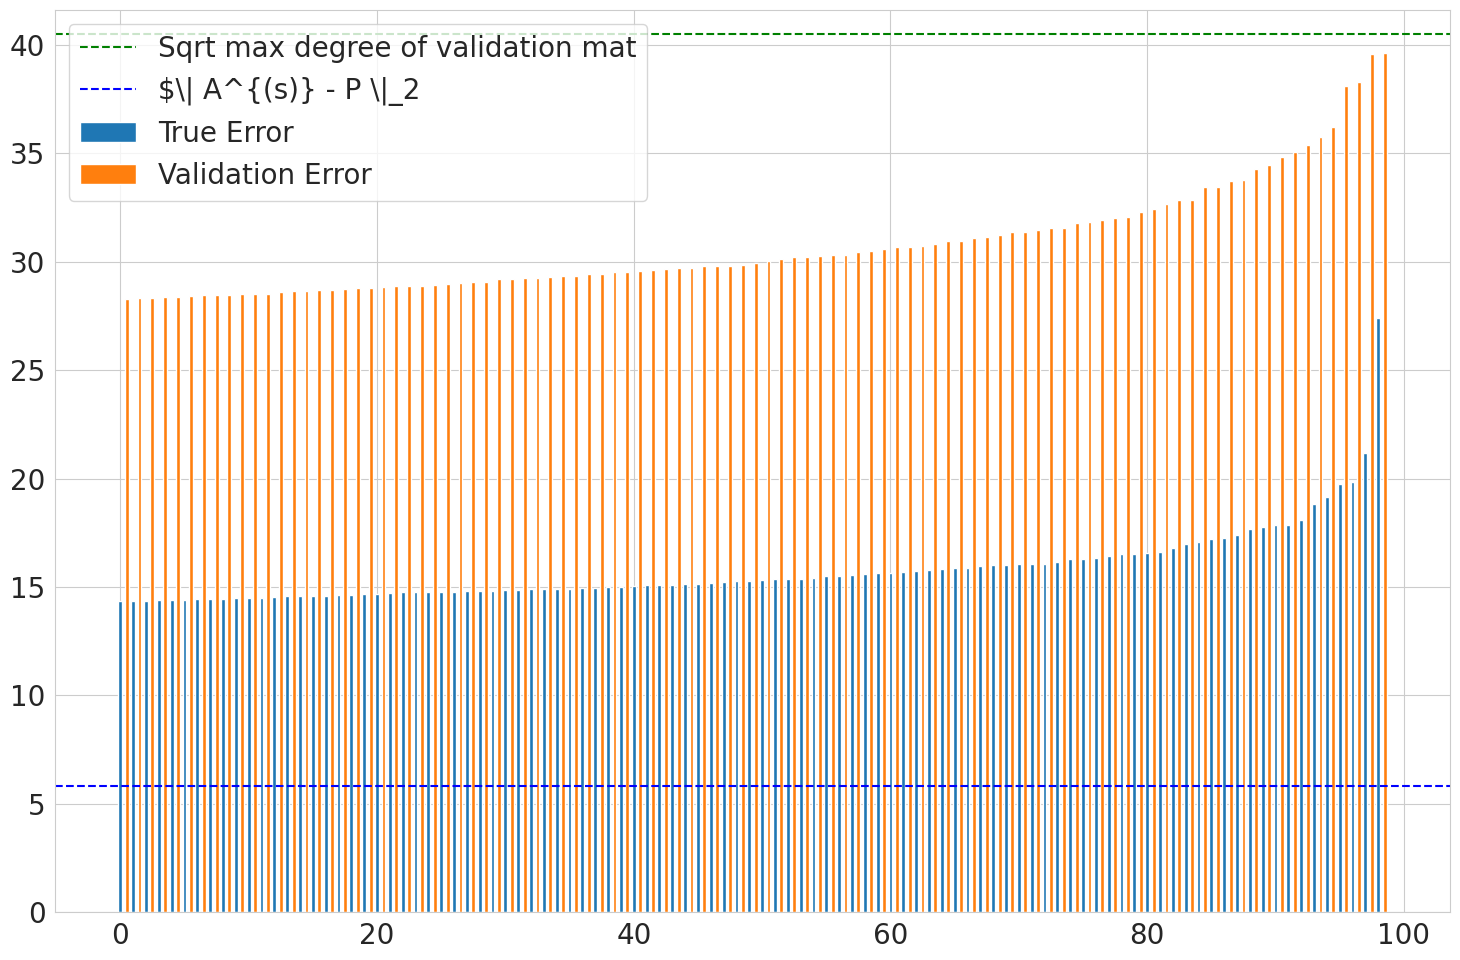

In [154]:

plt.bar(np.arange(len(true_diff_svals)), true_diff_svals, label='True Error', width=0.3)
plt.bar(np.arange(len(true_diff_svals)) + 0.5, validation_diff_svals, label='Validation Error', width=0.3)
plt.axhline(delta_est, ls='--', color='green', label='Sqrt max degree of validation mat')
plt.axhline(true_delta, ls='--', color='blue', label='$\| A^{(s)} - P \|_2')
plt.legend()
plt.tight_layout()

In [155]:
validation_diff_svals, true_diff_svals, delta_est, true_delta = result_diff(result_bfgs_first, sample_mats, 
                                                                            validation_mat, sparse_matrix, 100)

/home/akhil/miniconda3/envs/py3-akhil/lib/python3.10/site-packages/scipy/sparse/linalg/_eigen/_svds.py:491: UserWarning: Exited at iteration 20 with accuracies 
[7.45896015]
not reaching the requested tolerance 0.00017756223678588867.
Use iteration 14 instead with accuracy 
5.33613002617034.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/home/akhil/miniconda3/envs/py3-akhil/lib/python3.10/site-packages/scipy/sparse/linalg/_eigen/_svds.py:491: UserWarning: Exited postprocessing with accuracies 
[5.33613003]
not reaching the requested tolerance 0.00017756223678588867.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


[32.33527811645927,
 23.122626026453382,
 18.224714561534558,
 16.46732542122085,
 15.121979646404592,
 14.799452724265779,
 14.611040978323814,
 14.518024074342577,
 14.058257839175722,
 13.841736632131491,
 13.739422031503183,
 13.54288941274909,
 13.108328650430416,
 13.0946005670577,
 12.962417333387148,
 12.867501929025618,
 12.799527357600075,
 12.782307788682365,
 12.743258938555183,
 12.472535564623971,
 12.429430809981474,
 12.384017496040286,
 12.304046166314397,
 12.28474037200616,
 12.220676181417481,
 12.19532912332092,
 12.143711835769642,
 12.105374794137795,
 12.046198157153922,
 12.013237172273815,
 12.012827468132633,
 11.85277117799131,
 11.825322896331045,
 11.803720481946185,
 11.75267462425819,
 11.719274227417158,
 11.679216251402385,
 11.647179128922042,
 11.602790097228665,
 11.572180186069108,
 11.54828922274847,
 11.544609760669637,
 11.483994308864508,
 11.482416945268522,
 11.464165599871393,
 11.412411993272366,
 11.405356447119118,
 11.403963839787162,
 1

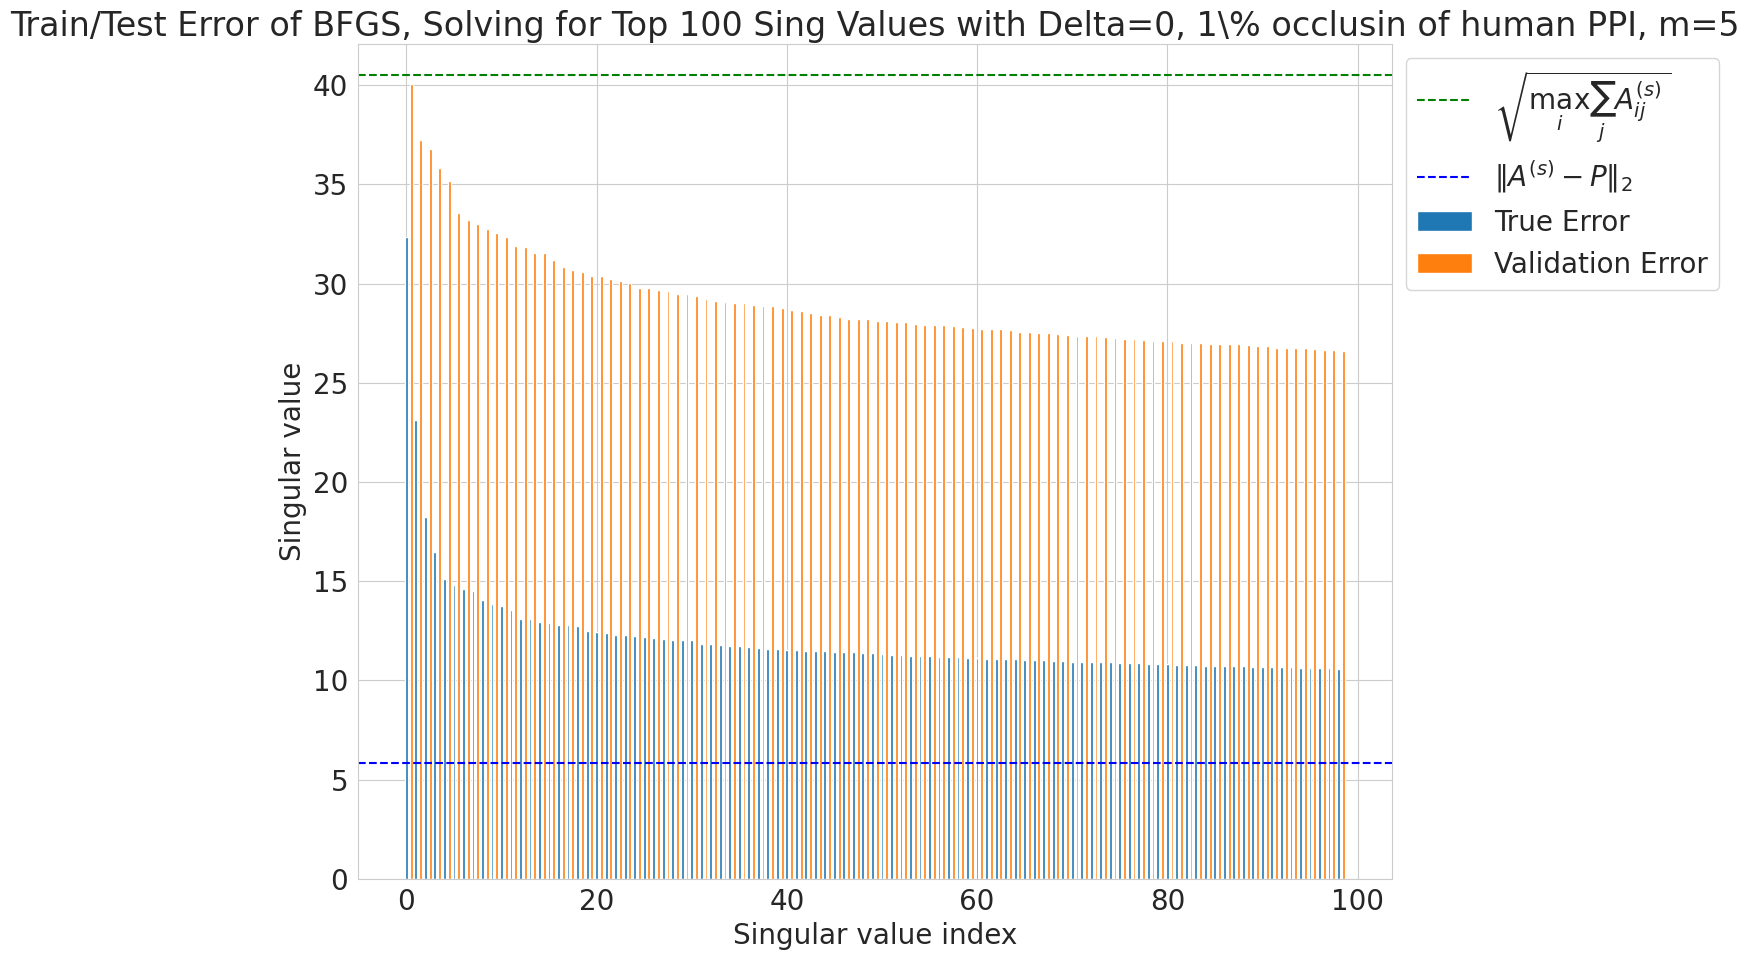

In [166]:
plt.bar(np.arange(len(true_diff_svals)), sorted(true_diff_svals, reverse=True), label='True Error', width=0.3)
plt.bar(np.arange(len(true_diff_svals)) + 0.5, sorted(validation_diff_svals, reverse=True), label='Validation Error', width=0.3)
plt.xlabel('Singular value index')
plt.ylabel('Singular value')
plt.title('Train/Test Error of BFGS, Solving for Top 100 Sing Values with Delta=0, 1\% occlusin of human PPI, m=5')
plt.axhline(delta_est, ls='--', color='green', label='$\sqrt{\max_i \sum_j A_{ij}^{(s)} }$')
plt.axhline(true_delta, ls='--', color='blue', label='$\| A^{(s)} - P \|_2$')
plt.legend(bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.savefig('figs/ppi-occlusion-tests/bfgs-short-run-results-occlusion-human-ppi.png')

### fastest SVD setup in scipy

In [170]:
%%time
num_sing_values = 50 
sing_vals_lobpcg = scipy.sparse.linalg.svds(sparse_matrix, k=num_sing_values, 
    solver='lobpcg',
    return_singular_vectors=False);

/home/akhil/miniconda3/envs/py3-akhil/lib/python3.10/site-packages/scipy/sparse/linalg/_eigen/_svds.py:491: UserWarning: Exited at iteration 20 with accuracies 
[1.82582945e-05 1.80305537e-06 1.10099511e-05 2.32106280e-05
 1.14400506e-06 4.61853038e-06 4.69951408e-06 6.94639359e-06
 1.50269908e-05 1.99421136e-05 1.52454378e-06 3.16756073e-06
 6.60963654e-06 1.02564202e-05 2.54194894e-05 2.78940075e-06
 3.78658795e-06 5.78165322e-06 9.78649779e-06 8.72546606e-06
 4.74172189e-06 4.19006717e-06 8.78154046e-06 1.45130054e-05
 9.08002597e-06 4.90648531e-05 1.16293827e-05 8.05975814e-06
 1.45355340e-05 1.51188968e-05 3.56328168e-05 7.42094715e-06
 1.50109521e-05 1.37376933e-05 2.68746945e-05 2.00214119e-05
 4.36173721e-05 2.63361414e-05 1.70273809e-05 6.83526698e-05
 3.81347815e-05 3.17354090e-05 6.58772616e-05 4.41568076e-05
 5.35399315e-05 8.95842961e-05 1.06627035e-04 1.12022800e-04
 9.77058037e-03 2.44613289e-01]
not reaching the requested tolerance 0.00017756223678588867.
Use iteration 

CPU times: user 1min 47s, sys: 5.66 s, total: 1min 52s
Wall time: 7.98 s


In [169]:
%%time
num_sing_values = 50 
sing_vals_arpack = scipy.sparse.linalg.svds(sparse_matrix, k=num_sing_values, 
    solver='arpack',
    return_singular_vectors=False);

CPU times: user 1min 17s, sys: 4.29 s, total: 1min 21s
Wall time: 3.58 s


In [171]:
sing_vals_arpack - sing_vals_lobpcg

array([ 4.86963558e-06,  6.32159924e-09,  5.25801624e-13,  4.12114787e-13,
        3.26849658e-13,  1.42108547e-14,  2.13162821e-14,  1.42108547e-13,
        4.26325641e-14, -4.97379915e-14,  8.52651283e-14, -7.10542736e-15,
        1.42108547e-14,  4.26325641e-14, -2.84217094e-14,  2.13162821e-14,
       -7.10542736e-15, -2.13162821e-14, -2.13162821e-14,  7.10542736e-15,
       -4.97379915e-14, -2.13162821e-14, -6.39488462e-14,  7.10542736e-15,
        4.26325641e-14,  2.13162821e-14, -7.10542736e-15,  7.10542736e-15,
        2.84217094e-14,  2.84217094e-14,  2.13162821e-14,  0.00000000e+00,
        2.13162821e-14,  4.97379915e-14, -4.26325641e-14, -2.13162821e-14,
       -7.10542736e-14, -2.84217094e-14,  5.68434189e-14, -5.68434189e-14,
       -1.42108547e-14, -1.42108547e-14,  0.00000000e+00, -4.26325641e-14,
        0.00000000e+00,  1.42108547e-14, -7.10542736e-14,  1.98951966e-13,
       -1.13686838e-13,  2.84217094e-14])

In [172]:
%%time
num_sing_values = 50 
sing_vals_arpack_shorter = scipy.sparse.linalg.svds(sparse_matrix, k=num_sing_values, 
    solver='arpack', ncv=num_sing_values + 1, 
    return_singular_vectors=False);

CPU times: user 7min 40s, sys: 23.7 s, total: 8min 4s
Wall time: 20.3 s


In [173]:
sing_vals_arpack_shorter - sing_vals_arpack

array([ 2.13162821e-14,  0.00000000e+00, -4.26325641e-14, -1.42108547e-14,
       -7.10542736e-15,  9.23705556e-14,  4.97379915e-14, -4.97379915e-14,
       -2.13162821e-14,  4.97379915e-14,  0.00000000e+00,  2.84217094e-14,
        0.00000000e+00,  2.13162821e-14,  2.84217094e-14, -2.84217094e-14,
        7.10542736e-15,  5.68434189e-14,  1.42108547e-14,  1.42108547e-14,
        1.42108547e-14,  3.55271368e-14,  5.68434189e-14,  2.84217094e-14,
        7.10542736e-15, -2.13162821e-14,  2.84217094e-14,  2.84217094e-14,
        2.84217094e-14, -3.55271368e-14,  0.00000000e+00,  0.00000000e+00,
       -4.26325641e-14, -4.97379915e-14,  4.26325641e-14,  7.10542736e-15,
        2.84217094e-14,  0.00000000e+00, -1.42108547e-14,  8.52651283e-14,
        8.52651283e-14,  5.68434189e-14, -1.42108547e-14,  5.68434189e-14,
       -4.26325641e-14, -2.84217094e-14,  5.68434189e-14,  0.00000000e+00,
        1.13686838e-13,  0.00000000e+00])

In [174]:
%%time
num_sing_values = 50 
sing_vals_arpack_shorter = scipy.sparse.linalg.svds(sparse_matrix, k=num_sing_values, 
    solver='arpack', ncv=int(num_sing_values * 1.5), 
    return_singular_vectors=False);

CPU times: user 1min 17s, sys: 4.14 s, total: 1min 21s
Wall time: 3.49 s


In [175]:
%%timeit
num_sing_values = 50 
sing_vals_arpack_shorter = scipy.sparse.linalg.svds(sparse_matrix, k=num_sing_values, 
    solver='arpack', ncv=int(num_sing_values * 2.0), 
    return_singular_vectors=False);

3.58 s ± 160 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [176]:
%%timeit
num_sing_values = 50 
sing_vals_arpack_shorter = scipy.sparse.linalg.svds(sparse_matrix, k=num_sing_values, 
    solver='arpack', ncv=int(num_sing_values * 1.5), 
    return_singular_vectors=False);

3.65 s ± 104 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [177]:
%%timeit
num_sing_values = 50 
sing_vals_arpack_shorter = scipy.sparse.linalg.svds(sparse_matrix, k=num_sing_values, 
    solver='arpack', ncv=int(num_sing_values * 1.8), 
    return_singular_vectors=False);

3.49 s ± 39.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [178]:
%%timeit
num_sing_values = 50 
sing_vals_arpack_less_iter = scipy.sparse.linalg.svds(sparse_matrix, k=num_sing_values, 
    solver='arpack', maxiter=sparse_matrix.shape[0] * 2,
    return_singular_vectors=False)

3.54 s ± 62.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [179]:
%%timeit
num_sing_values = 50 
sing_vals_arpack_tol_higher = scipy.sparse.linalg.svds(sparse_matrix, k=num_sing_values, 
    solver='arpack', tol=1e-5, return_singular_vectors=False)

3.64 s ± 112 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [183]:
sing_vals_arpack_tol_higher = scipy.sparse.linalg.svds(sparse_matrix, k=num_sing_values, 
    solver='arpack', tol=1e-5, return_singular_vectors=False)

In [181]:
sing_vals_arpack_less_iter - sing_vals_arpack

NameError: name 'sing_vals_arpack_less_iter' is not defined

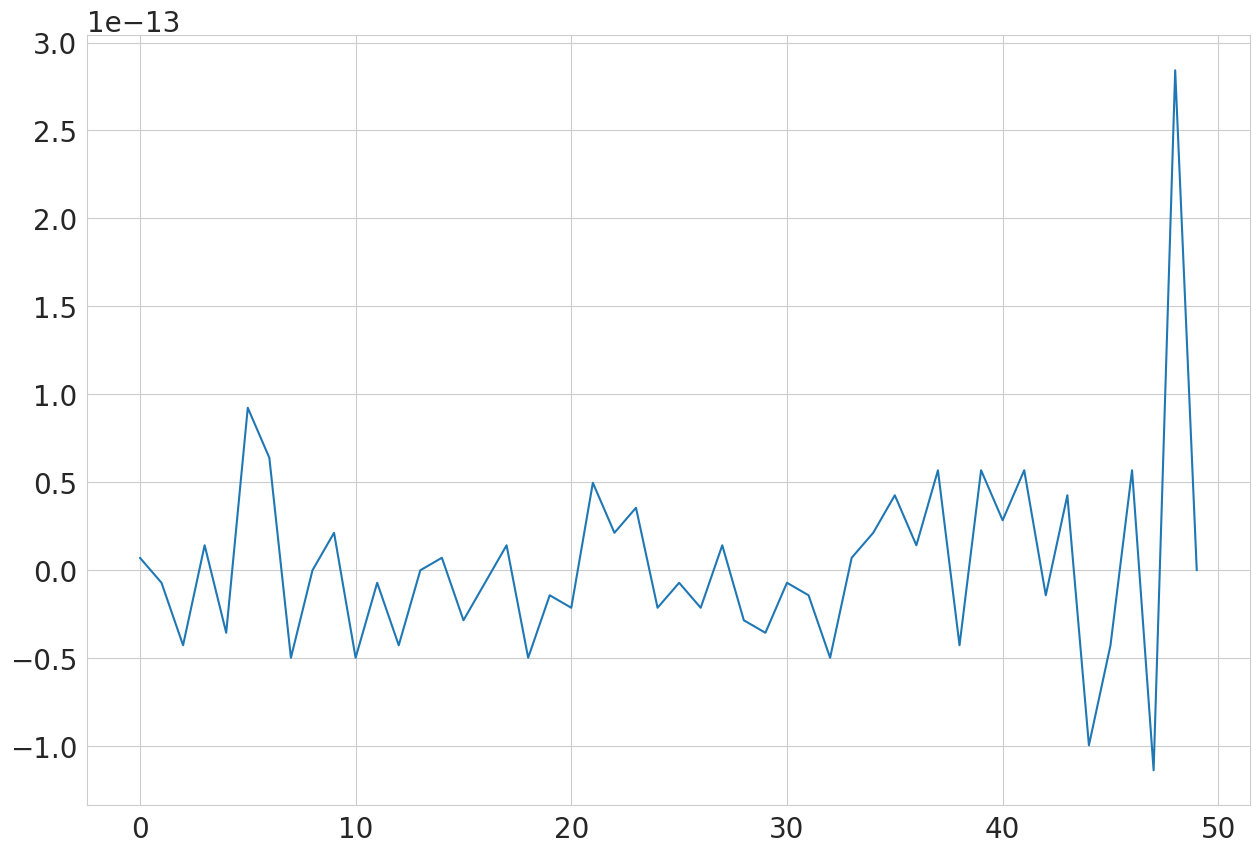

In [185]:
plt.plot(sing_vals_arpack_tol_higher - sing_vals_arpack)

In [187]:
sorted(sing_vals_arpack, reverse=True)

[254.44138008104454,
 175.52968777530356,
 129.47383593687007,
 122.16335928608824,
 105.86666657104817,
 96.21529262086007,
 94.10098879521473,
 90.30722476603046,
 83.17067117283173,
 81.68316980681274,
 75.39271219821781,
 72.44979419777957,
 68.42870155774403,
 66.5648901629456,
 63.59520229793015,
 61.00487045956507,
 59.53058509893423,
 57.4826511192674,
 54.84215069162135,
 51.655105540332386,
 51.22361606864577,
 50.61475867139682,
 49.46950631332483,
 49.35446243500618,
 48.50392235481171,
 46.516058993357774,
 46.281660626895885,
 45.717834674113995,
 45.613563708265,
 44.585746711913906,
 43.7348396518999,
 43.07024536118684,
 42.09892719873795,
 41.1709467583836,
 40.44477814679556,
 40.04957368023184,
 39.6580488850023,
 39.491966752093596,
 39.28670052146028,
 38.186605686988024,
 37.921166180801634,
 37.253504077845086,
 36.59421136917407,
 36.451061311317964,
 36.0656589223393,
 35.40875563934913,
 35.377235220479996,
 35.20883564425026,
 34.46201616654384,
 34.22966855

## BFGS run with k = 10, and way more iterations

In [196]:
%%time
delta = 0.1
k = 10
objective = lambda eta_arr: objective_with_params_sparse(eta_arr, validation_mat, sample_mats, delta, num_eigs_included=k,
                                                         verbose=True)

bfgs_options = {
    'iprint': 5, 
    'maxiter': 500, 
    # 'maxfun': 2,
    # 'maxls': 3, 
    'ftol': 1e-4, 
    'gtol': 1e-4, 
}

result = scipy.optimize.minimize(
    objective,
    eta_init,
    method='L-BFGS-B',
    jac=None,
    bounds=[(0, 1) for _ in range(len(sample_mats))],
    options=bfgs_options
)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.35352D+02    |proj g|=  9.87119D-01

At iterate    5    f=  3.11151D+02    |proj g|=  2.27774D-01
CPU times: user 1h 6min 1s, sys: 3min 40s, total: 1h 9min 42s
           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      8     12     12     0     0   8.149D-01   3.103D+02
  F =   310.26808968598891     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             

Wall time: 3min


In [197]:
result

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 310.2680896859889
        x: [ 1.881e-01  1.851e-01  1.930e-01  1.984e-01  1.938e-01]
      nit: 8
      jac: [-1.582e+00 -1.592e+00 -1.978e+00 -1.143e+00 -1.884e+00]
     nfev: 72
     njev: 12
 hess_inv: <5x5 LbfgsInvHessProduct with dtype=float64>

In [206]:
def plot_result_and_save(result, sample_mats, validation_mat, ground_truth_matrix, 
                         num_eigs_solver, num_eigs_to_show, 
                         savepath=None): 
    validation_diff_svals, true_diff_svals, delta_est, true_delta = result_diff(result, sample_mats, 
        validation_mat, ground_truth_matrix, num_eigs_to_show)


    plt.bar(np.arange(len(true_diff_svals)), sorted(true_diff_svals, reverse=True), 
            label='True Diff', width=0.3)
    plt.bar(np.arange(len(true_diff_svals)) + 0.5, sorted(validation_diff_svals, reverse=True), 
            label='Validation Diff', width=0.3)
    plt.xlabel('Index')
    plt.ylabel('Singular value')
    plt.axhline(delta_est, ls='--', color='green', label='$\sqrt{\max_i \sum_j A_{ij}^{(s)} }$')
    plt.axhline(true_delta, ls='--', color='blue', label='$\| A^{(s)} - P \|_2$')
    plt.legend()
    plt.tight_layout()
    plt.title('Train/Test Error, Solving for {} Sing Values, Occlusion Test of Human PPI with m=5, Occlusion level=1\%'.format(num_eigs_solver))
    if savepath is not None: 
        plt.savefig(savepath, dpi=400.0)

/home/akhil/miniconda3/envs/py3-akhil/lib/python3.10/site-packages/scipy/sparse/linalg/_eigen/_svds.py:491: UserWarning: Exited at iteration 20 with accuracies 
[0.9837419]
not reaching the requested tolerance 0.00017756223678588867.
Use iteration 21 instead with accuracy 
0.9837419034566066.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/home/akhil/miniconda3/envs/py3-akhil/lib/python3.10/site-packages/scipy/sparse/linalg/_eigen/_svds.py:491: UserWarning: Exited postprocessing with accuracies 
[0.9837419]
not reaching the requested tolerance 0.00017756223678588867.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


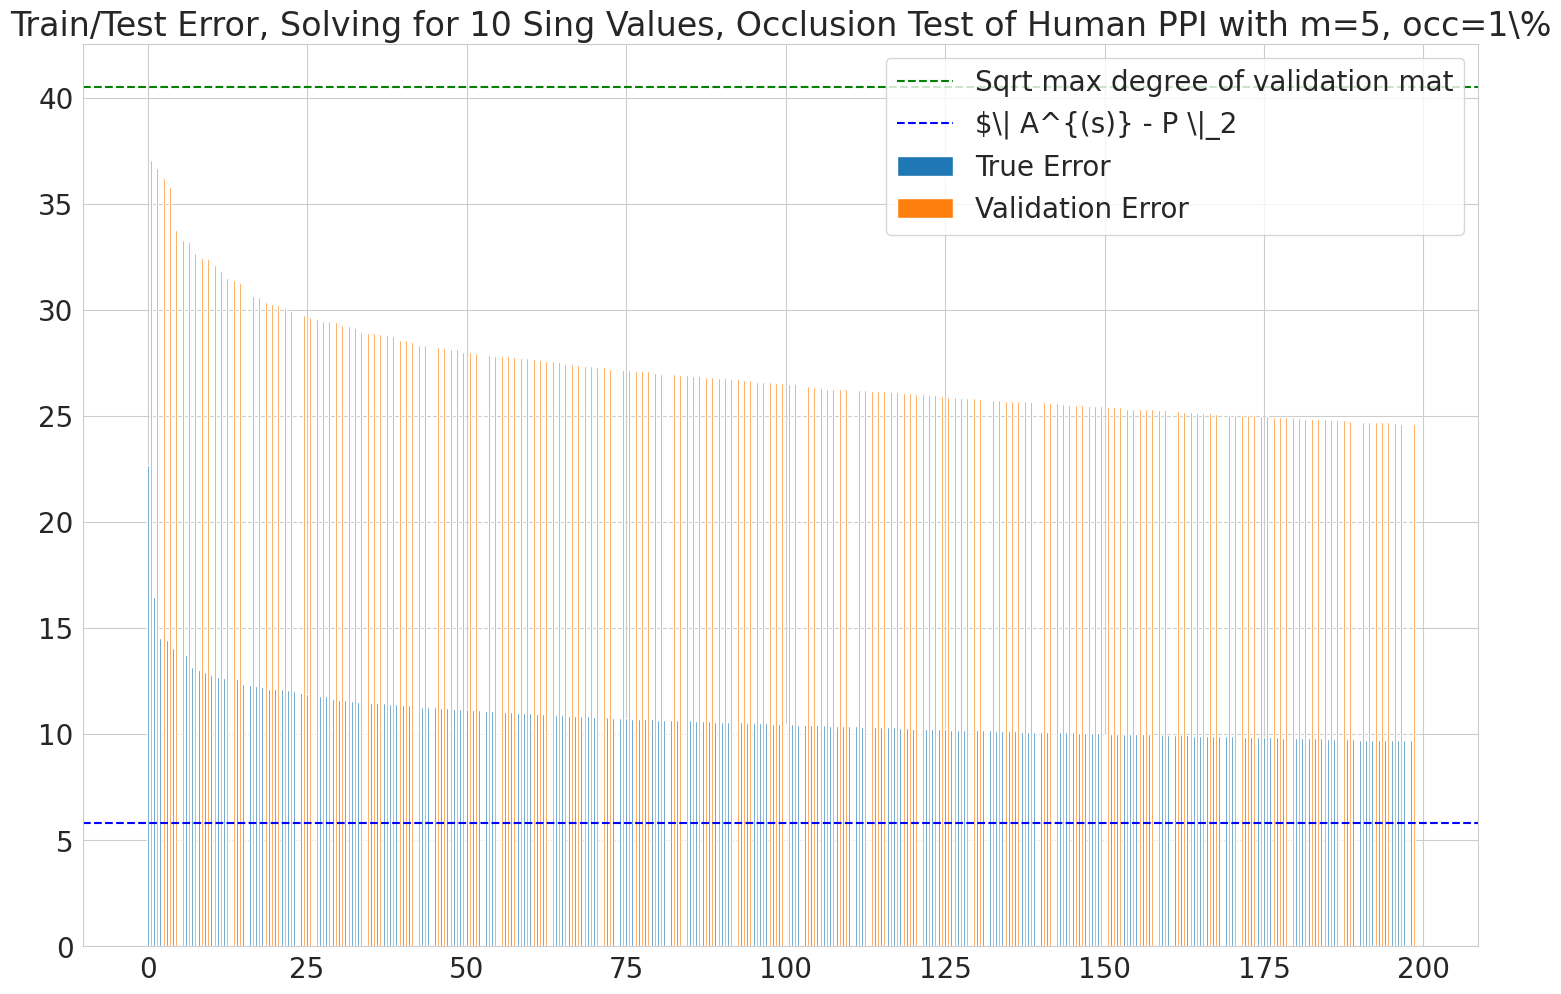

In [199]:
plot_result_and_save(result, sample_mats, validation_mat, sparse_matrix, 10, 200)

## BFGS with much stronger ftol and gtol 

In [200]:
%%time
delta = 0.1
k = 5
objective = lambda eta_arr: objective_with_params_sparse(eta_arr, validation_mat, sample_mats, delta, num_eigs_included=k,
                                                         verbose=True)

bfgs_options = {
    'iprint': 5, 
    'maxiter': 500, 
    # 'maxfun': 2,
    # 'maxls': 3, 
    'ftol': 1e-7, 
    'gtol': 1e-7, 
}

result = scipy.optimize.minimize(
    objective,
    eta_init,
    method='L-BFGS-B',
    jac=None,
    bounds=[(0, 1) for _ in range(len(sample_mats))],
    options=bfgs_options
)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.56819D+02    |proj g|=  9.87119D-01

At iterate    5    f=  1.46400D+02    |proj g|=  8.93235D-01

At iterate   10    f=  1.45335D+02    |proj g|=  1.98354D-01
CPU times: user 1h 8min 5s, sys: 3min 46s, total: 1h 11min 51s
At iterate   15    f=  1.45335D+02    |proj g|=  1.08258D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     15     19     20     0     0   1.083D-02   1.453D+02
  F =   145.33453163774371     

CONVERG

/home/akhil/miniconda3/envs/py3-akhil/lib/python3.10/site-packages/scipy/sparse/linalg/_eigen/_svds.py:491: UserWarning: Exited at iteration 20 with accuracies 
[1.14402936]
not reaching the requested tolerance 0.00017756223678588867.
Use iteration 21 instead with accuracy 
1.1440293601702192.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/home/akhil/miniconda3/envs/py3-akhil/lib/python3.10/site-packages/scipy/sparse/linalg/_eigen/_svds.py:491: UserWarning: Exited postprocessing with accuracies 
[1.14402936]
not reaching the requested tolerance 0.00017756223678588867.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


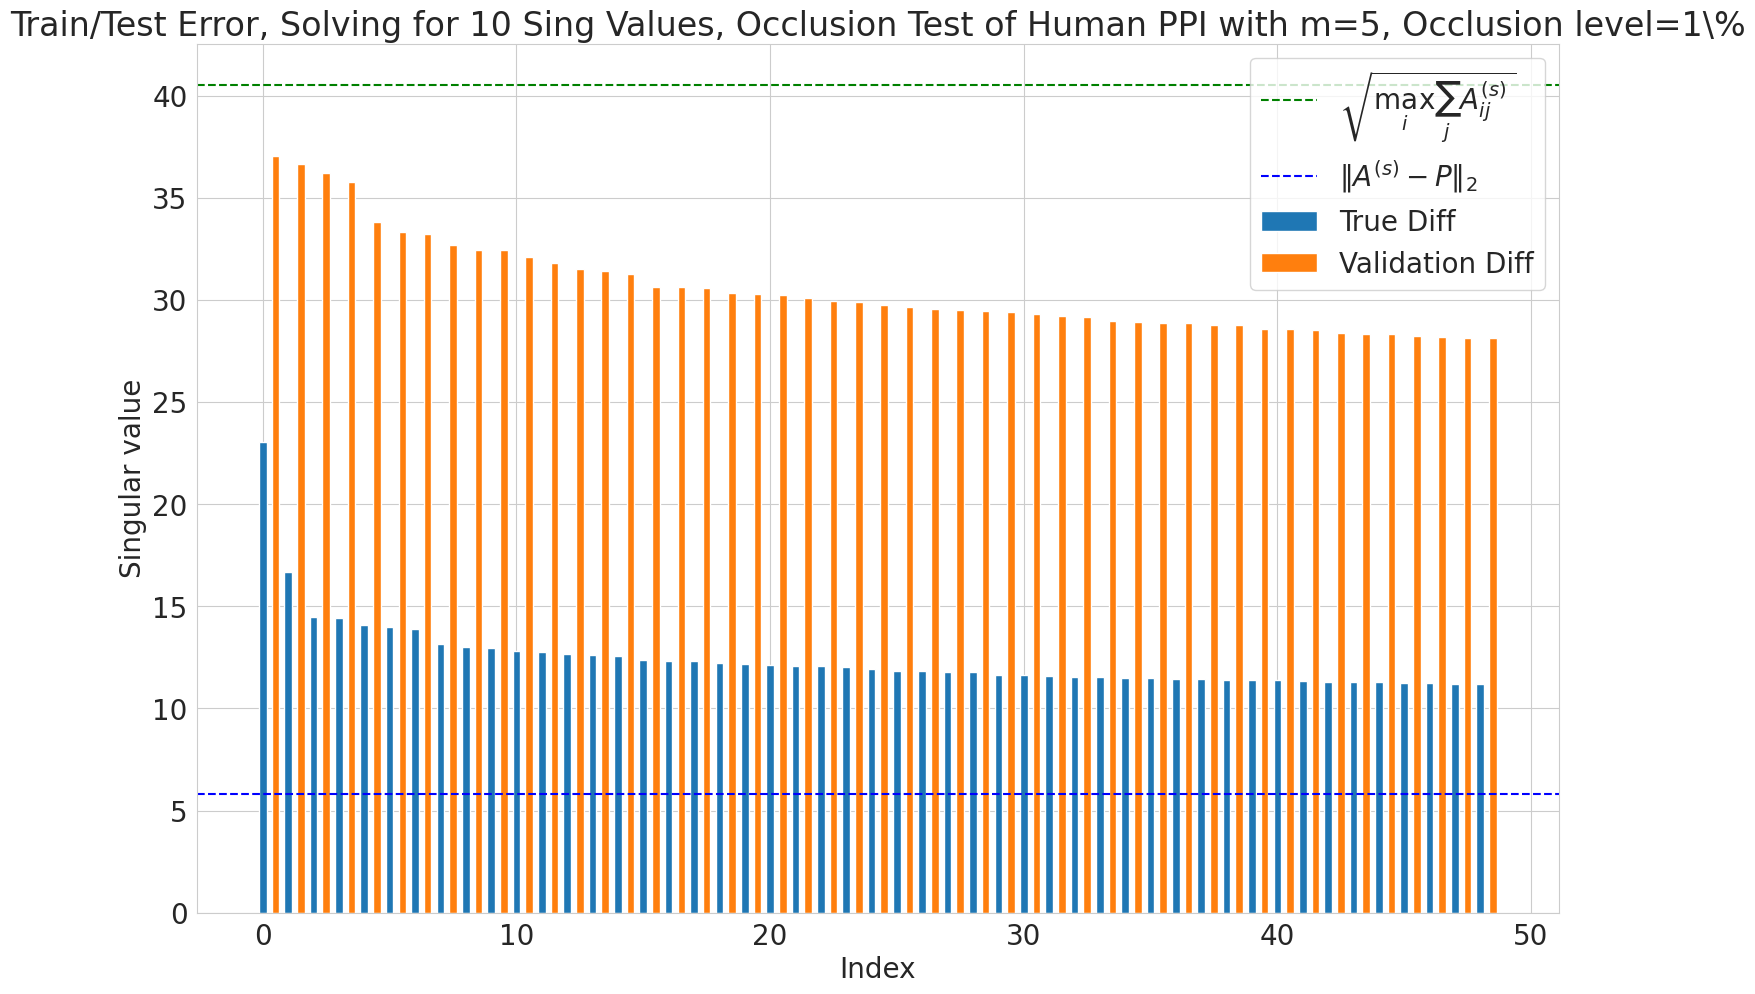

In [207]:
plot_result_and_save(result, sample_mats, validation_mat, sparse_matrix, 10, 50, 
                     savepath='figs/ppi-occlusion-tests/bfgs_test_high_ftol_occlusion.png')

In [208]:
result_bfgs_1e7 = result.copy()

In [209]:
%%time
delta = 0.0
k = 5
objective = lambda eta_arr: objective_with_params_sparse(eta_arr, validation_mat, sample_mats, delta, num_eigs_included=k,
                                                         verbose=True)

bfgs_options = {
    'iprint': 5, 
    'maxiter': 500, 
    # 'maxfun': 2,
    # 'maxls': 3, 
    'ftol': 1e-10, 
    'gtol': 1e-10, 
}

result = scipy.optimize.minimize(
    objective,
    eta_init,
    method='L-BFGS-B',
    jac=None,
    bounds=[(0, 1) for _ in range(len(sample_mats))],
    options=bfgs_options
)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.57219D+02    |proj g|=  9.87119D-01

At iterate    5    f=  1.46800D+02    |proj g|=  8.93234D-01

At iterate   10    f=  1.45735D+02    |proj g|=  1.98354D-01

At iterate   15    f=  1.45735D+02    |proj g|=  1.07775D-02
CPU times: user 1h 16min 16s, sys: 4min 14s, total: 1h 20min 31s
           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches

Wall time: 3min 33s
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     17     21     22     0     0   5.770D-04   1.457D+02
  F =   145.73453

In [210]:
result

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 145.73453154283774
        x: [ 1.749e-01  2.041e-01  1.882e-01  1.971e-01  1.922e-01]
      nit: 17
      jac: [ 4.292e-04 -5.770e-04 -2.814e-04 -5.684e-04 -3.979e-05]
     nfev: 126
     njev: 21
 hess_inv: <5x5 LbfgsInvHessProduct with dtype=float64>

/home/akhil/miniconda3/envs/py3-akhil/lib/python3.10/site-packages/scipy/sparse/linalg/_eigen/_svds.py:491: UserWarning: Exited at iteration 20 with accuracies 
[0.98020703]
not reaching the requested tolerance 0.00017756223678588867.
Use iteration 21 instead with accuracy 
0.9802070284444047.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/home/akhil/miniconda3/envs/py3-akhil/lib/python3.10/site-packages/scipy/sparse/linalg/_eigen/_svds.py:491: UserWarning: Exited postprocessing with accuracies 
[0.98020703]
not reaching the requested tolerance 0.00017756223678588867.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


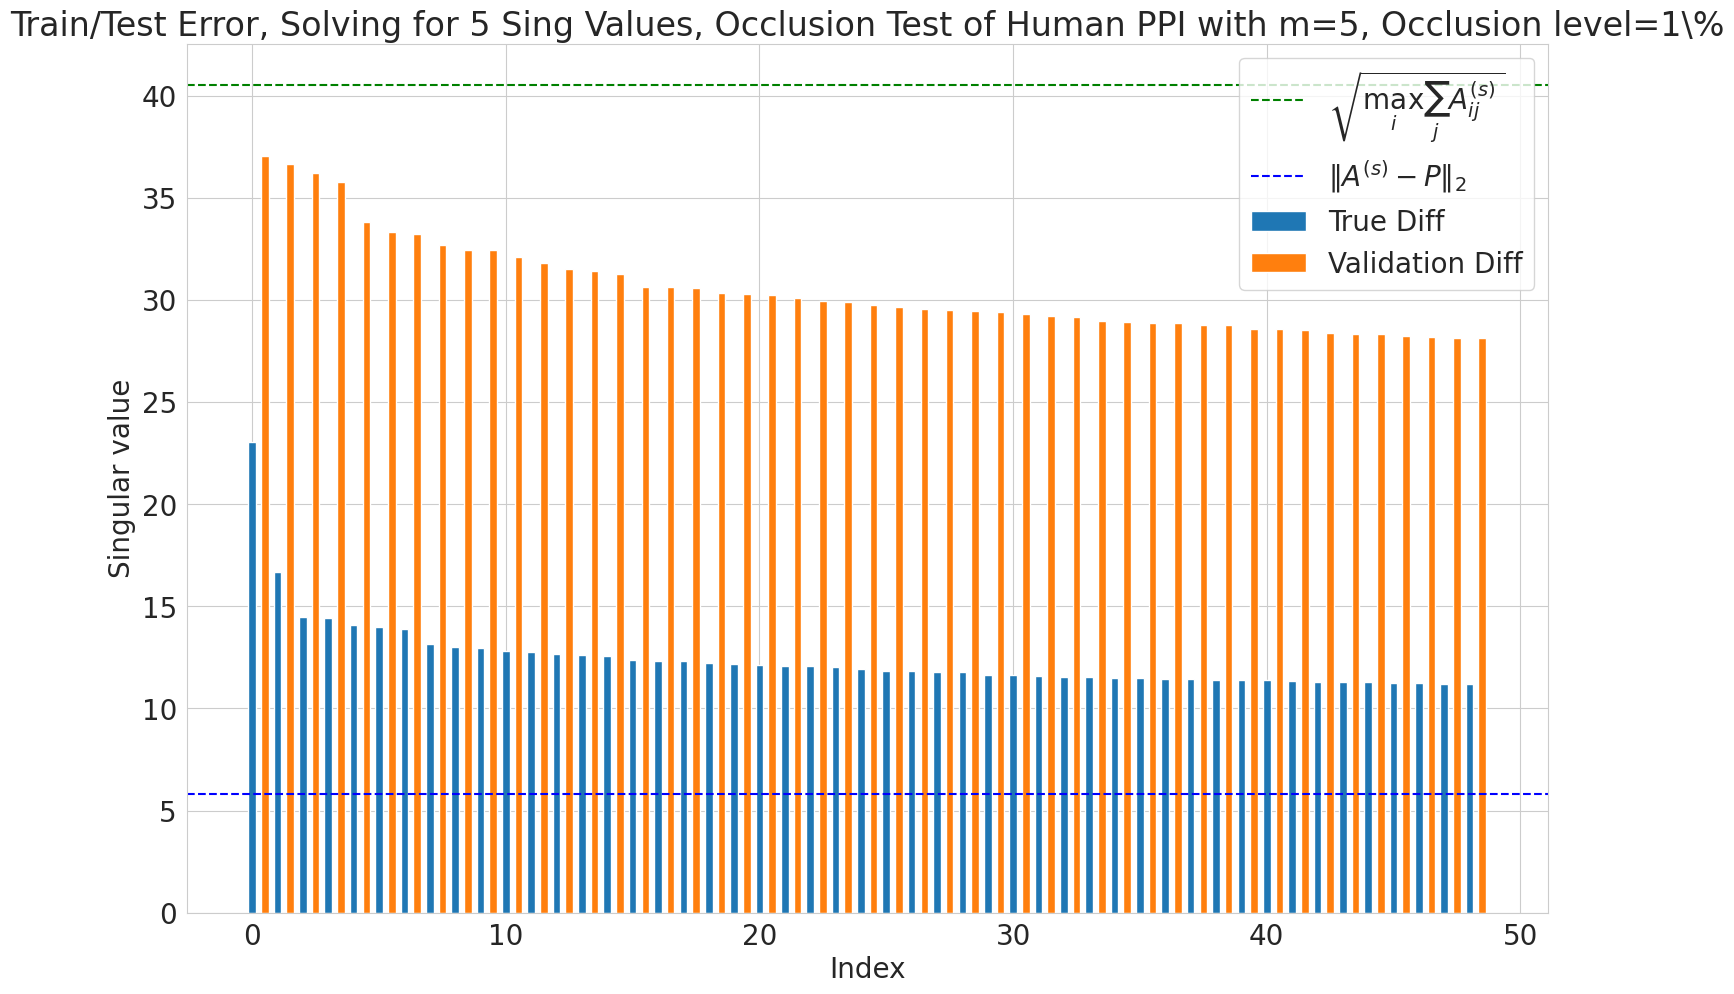

In [212]:
plot_result_and_save(result, sample_mats, validation_mat, sparse_matrix, k, 50, 
                     savepath='figs/ppi-occlusion-tests/bfgs_test_ftol_1e10_occlusion.png')

In [213]:
result['x'] - result_bfgs_1e7['x']

array([-6.15083274e-06, -2.43626829e-05,  1.65012928e-05,  1.35594634e-05,
       -4.95682373e-06])

# Stochastic Blockmodel

(todo move this to another notebook).

In [98]:
k = 2 
n = 200
comm_size = int(n / k)
p_in = 0.5
p_out = 0.1
probs_mat = p_out * np.ones((2, 2)) + (p_in - p_out) * np.diag(np.ones(2))

In [99]:
probs_mat

array([[0.5, 0.1],
       [0.1, 0.5]])

In [100]:
G_sbm = nx.stochastic_block_model(sizes=[comm_size for _ in range(k)], 
                          p=probs_mat)